In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy as sp
from scipy.optimize import minimize
from scipy.stats import norm

from KalmanFilter import KalmanFilter


We'll first estimate the local level model giving us the chance of writing the Kalman filter algorithm which, if there's time, can be re-used for the DSGE model.

# The Model

as described in the chapter 4 in Koopman et al. The local level model with a seasonal component consists of the following equations:

$$y_t = \mu_t + \gamma_t + \epsilon_t, \qquad \epsilon_t \sim NID(0,\sigma^2_\epsilon)$$

$$\mu_{t+1} = \mu_t + \xi_t, \qquad \xi_t \sim NID(0,\sigma^2_\xi) $$

$$\gamma_{t+1} = -\gamma_{t} - \gamma_{t-1} - \theta_1\gamma_{t-2} + \omega_t \sim NID(0,\sigma^2_\omega) $$


We added a $\theta$ coefficient in order to use maximum likelihood estimation

## State Space Form

General Form:

$$ y_t = Z x_t + \epsilon_t, \qquad \epsilon_t \sim NID(0,\sigma^2_\epsilon)$$
$$ x_{t+1} = T x_t + R_t \eta_T, \qquad \eta_t \sim NID(0,Qt) $$

In terms of the model:
$$ 
x_t = 
\begin{pmatrix}\mu_t \\ \gamma_t  \\  \gamma_{t-1}   \\ \gamma_{t-2}  \end{pmatrix}
$$

$$
\eta_t = 
\begin{pmatrix}\xi_t \\ \omega_t \end{pmatrix}
$$

$$
T_t = 
\begin{bmatrix} 
1 & 0 & 0 & 0 \\
0 & -1 & -1 & -\theta_1 \\
0 & 1 & 0 & 0 \\
0 & 0 & 1 & 0 
\end{bmatrix}
$$


$$
Z^T_t = 
\begin{pmatrix}1 \\ 1  \\  0   \\ 0  \end{pmatrix}
$$

$$
Q_t = 
\begin{bmatrix} 
\sigma^2_\xi & 0 \\
0 & \sigma^2_\omega \\
\end{bmatrix}
$$

$$
R_t = 
\begin{bmatrix} 
1 & 0  \\
0 & 1  \\
0 & 0  \\
0 & 0  \\
\end{bmatrix}
$$

# Generating the data for $\theta_1=1$

We have to choose all parameter values plus the initial states

$$\gamma_t = \gamma_{t-1} = \gamma_{t-2} = 0$$
$$\theta_1 = 0.7$$
$$\sigma^2_\xi = 2$$
$$\omega^2_\zeta = 0.2$$
$$\sigma^2_\epsilon = 0.3$$

$$y_t = \mu_t + \gamma_t + \epsilon_t, \qquad \epsilon_t \sim NID(0,\sigma^2_\epsilon)$$

$$\mu_{t+1} = \mu_t + \xi_t, \qquad \xi_t \sim NID(0,\sigma^2_\xi) $$

$$\gamma_{t+1} = -\gamma_{t} - \gamma_{t-1} - \theta_1\gamma_{t-2} + \omega_t \sim NID(0,\sigma^2_\omega) $$


In [3]:
n = 1000
theta1 = 1
sigmaXi = 0.1
sigmaOmega = 0.2
sigmaEpsilon = 0.3

In [4]:
y = np.array([0])
mi = np.array([0])
gamma = np.array([0])

xi = np.array([0])
omega = np.array([0])
ep = np.array([0])

for i in range(1,n):

    # Level equation
    xi = np.append(xi,np.random.normal(scale=sigmaXi))
    mi = np.append(mi,mi[i-1]+xi[i])
    
    # Seasonality equation
    omega = np.append(omega,np.random.normal(scale=sigmaOmega))
    holder = 0
    if i-1 >= 0:
        holder -= gamma[i-1] 
    if i-2 >= 0:
        holder -= gamma[i-2] 
    if i-3 >= 0:
        holder -= gamma[i-3] * theta1
    
    gamma = np.append(gamma,holder+omega[i])
    
    # Series equation
    ep = np.append(ep,np.random.normal(scale=sigmaEpsilon))
    y = np.append(y,mi[i]+gamma[i]+ep[i])

y = pd.DataFrame(y) 
mi = pd.DataFrame(mi) 
gamma = pd.DataFrame(gamma) 

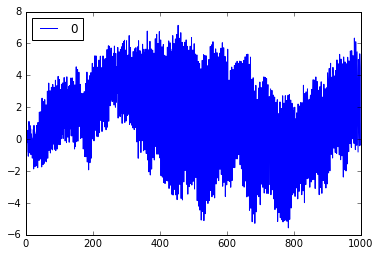

In [5]:
y.plot()

## Filtering States

In [6]:
T = pd.DataFrame([
        [1,0,0,0],
        [0,-1,-1,-1],
        [0,1,0,0],
        [0,0,1,0],
    ])
T

,0,1,2,3
0,1,0,0,0
1,0,-1,-1,-1
2,0,1,0,0
3,0,0,1,0


In [7]:
Z = pd.DataFrame([
        [1,1,0,0],
    ])
Z

,0,1,2,3
0,1,1,0,0


In [8]:
R = pd.DataFrame([
        [1,0],
        [0,1],
        [0,0],
        [0,0],
    ])
R

,0,1
0,1,0
1,0,1
2,0,0
3,0,0


In [9]:
H = pd.DataFrame([0.3])
H

,0
0,0.3


In [10]:

Q = pd.DataFrame([
        [0.1,0],
        [0,0.2],
    ])
Q

,0,1
0,0.1,0.0
1,0.0,0.2


In [11]:
a1 = pd.DataFrame([0,0,0,0])
a1

,0
0,0
1,0
2,0
3,0


In [12]:
P1 = pd.DataFrame(np.diag([1,1,1,1]))
P1

,0,1,2,3
0,1,0,0,0
1,0,1,0,0
2,0,0,1,0
3,0,0,0,1


In [13]:
kf = KalmanFilter(y=y, Z=Z, H=H, T=T, Q=Q, a1=a1, P1=P1, R=R, nStates=4)
kf.runFilter()

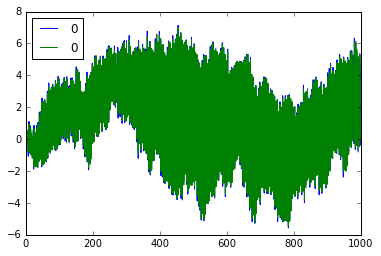

In [14]:
pd.concat([kf.y , kf.yhat],axis=1).plot()

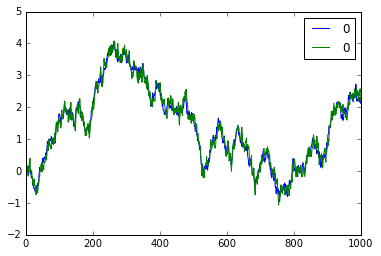

In [15]:
pd.concat([mi , kf.a[0]],axis=1).plot()

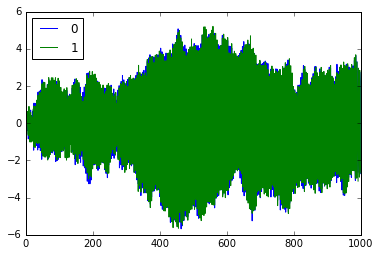

In [16]:
pd.concat([gamma , kf.a[1]],axis=1).plot()

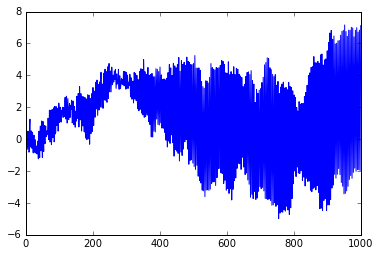

In [17]:
(kf.a[0]-kf.a[0]-kf.a[1]).plot()

# Maximum likelihood estimates

## Generating the data for $\theta_1=0.3$

We have to choose all parameter values plus the initial states

$$\gamma_t = \gamma_{t-1} = \gamma_{t-2} = 0$$
$$\theta_1 = 0.7$$
$$\sigma^2_\xi = 2$$
$$\omega^2_\zeta = 0.2$$
$$\sigma^2_\epsilon = 0.3$$

$$y_t = \mu_t + \gamma_t + \epsilon_t, \qquad \epsilon_t \sim NID(0,\sigma^2_\epsilon)$$

$$\mu_{t+1} = \mu_t + \xi_t, \qquad \xi_t \sim NID(0,\sigma^2_\xi) $$

$$\gamma_{t+1} = -\gamma_{t} - \gamma_{t-1} - \theta_1\gamma_{t-2} + \omega_t \sim NID(0,\sigma^2_\omega) $$


In [119]:
n = 150
theta1 = 0.2
sigmaXi = 0.1
sigmaOmega = 0.2
sigmaEpsilon = 0.3

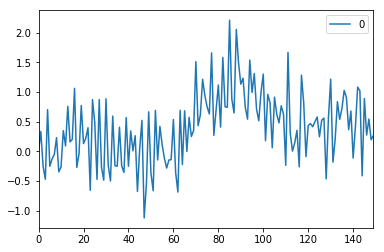

In [121]:
y = np.array([0])
mi = np.array([0])
gamma = np.array([0])

xi = np.array([0])
omega = np.array([0])
ep = np.array([0])

for i in range(1,n):

    # Level equation
    xi = np.append(xi,np.random.normal(scale=sigmaXi))
    mi = np.append(mi,mi[i-1]+xi[i])
    
    # Seasonality equation
    omega = np.append(omega,np.random.normal(scale=sigmaOmega))
    holder = 0
    if i-1 >= 0:
        holder -= gamma[i-1] 
    if i-2 >= 0:
        holder -= gamma[i-2] 
    if i-3 >= 0:
        holder -= gamma[i-3] * theta1
    
    gamma = np.append(gamma,holder+omega[i])
    
    # Series equation
    ep = np.append(ep,np.random.normal(scale=sigmaEpsilon))
    y = np.append(y,mi[i]+gamma[i]+ep[i])

y = pd.DataFrame(y) 
mi = pd.DataFrame(mi) 
gamma = pd.DataFrame(gamma) 

y.plot()

$$
T_t = 
\begin{bmatrix} 
1 & 0 & 0 & 0 \\
0 & -1 & -1 & -\theta_1 \\
0 & 1 & 0 & 0 \\
0 & 0 & 1 & 0 
\end{bmatrix}
$$



In [112]:
def wrapper(theta):
    T = pd.DataFrame([
        [1,0,0,0],
        [0,-1,-1,-theta[0]],
        [0,1,0,0],
        [0,0,1,0],
    ])

    H = pd.DataFrame([theta[1]])

    Q = pd.DataFrame([
        [theta[2],0],
        [0,theta[3]],
    ])

    kf = KalmanFilter(y=y, 
                      Z=Z.astype(float), 
                      H=H.astype(float), 
                      T=T.astype(float), 
                      Q=Q.astype(float), 
                      a1=a1.astype(float), 
                      P1=P1.astype(float), 
                      R=R.astype(float), 
                      nStates=4)    

    return kf.likelihood()


In [19]:
KalmanFilter(y=y, Z=Z, H=H, T=T, Q=Q, a1=a1, P1=P1, R=R, nStates=4).likelihood()

178.72235238157506

In [124]:
# minimize(wrapper,np.array([0.0,1.0,1.0,1.0]), options={'disp':True, 'maxiter':100}, method='BFGS')

# minimize(wrapper,np.array([0.0,1.0,1.0,1.0]), 
#          options={'disp':True, 'maxiter':200}, 
#          bounds = ((-5,5),(0,5),(0,5),(0,5),), 
#          method='SLSQP',
#          )

minimize(wrapper,np.array([0.0,1.0,1.0,1.0]), 
         options={'disp':True, 'maxiter':200}, 
         bounds = ((-5,5),(None,None),(None,None),(None,None),), 
         method='SLSQP',
         )

# minimize(wrapper,np.array([0.0,1.0,1.0]), 
#          options={'disp':True, 'maxiter':1000}, 
#          bounds = ((0,2),(0,2),(0,2),),
#          method='SLSQP')

C:\Anaconda3\lib\site-packages\scipy\optimize\slsqp.py:341: RuntimeWarning: invalid value encountered in greater
  bnderr = bnds[:, 0] > bnds[:, 1]
O:\SALES\Fundos de Mercado\Notebooks\Bayesian Econometrics\KalmanFilter.py:168: RuntimeWarning: invalid value encountered in log
  ll += np.log(det(self.Ft[i])) +  self.vt[i].T.dot(inv(self.Ft[i])).dot(self.vt[i])


Optimization terminated successfully.    (Exit mode 0)
            Current function value: 95.70628523661136
            Iterations: 32
            Function evaluations: 302
            Gradient evaluations: 31


     fun: 95.70628523661136
     jac: array([-0.01836014, -0.01606941, -0.08957958,  0.07501793])
 message: 'Optimization terminated successfully.'
    nfev: 302
     nit: 32
    njev: 31
  status: 0
 success: True
       x: array([ 0.18854634,  0.07107225,  0.00734111,  0.03904031])

# Bayesian Estimates

## Metropolis Hastings

---
**Metropolis-Hastings Algoritm**

Guess $\theta^{(0)}$ and for $i=0$ until $n$: 
1. $\theta=\theta^{(i)}$
Draw $\theta'\sim q(\theta'|\theta)$
2. Compute $r=\min(1,\alpha)$ where $\alpha= \frac{p(\theta')q(\theta|\theta')}{p(\theta)q(\theta'|\theta)}$
4. Draw $u\sim U(0,1)$
5. $\theta^{(i+1)}=\begin{cases}\theta' & \text{if $u<r$}\\\theta & \text{if $u\geq r$}\end{cases}$

---

In [ ]:
def wrapper(theta):
    T = pd.DataFrame([
        [1,0,0,0],
        [0,-1,-1,-theta[0]],
        [0,1,0,0],
        [0,0,1,0],
    ])

    H = pd.DataFrame([theta[1]])

    Q = pd.DataFrame([
        [theta[2],0],
        [0,theta[3]],
    ])

    kf = KalmanFilter(y=y, 
                      Z=Z.astype(float), 
                      H=H.astype(float), 
                      T=T.astype(float), 
                      Q=Q.astype(float), 
                      a1=a1.astype(float), 
                      P1=P1.astype(float), 
                      R=R.astype(float), 
                      nStates=4)    

    return kf.likelihood()


In [34]:
def posterior(theta,priorMeans, priorVariances):
    
    temp = 1
    for i in range(0,priorMeans.shape[0]):
        temp *= norm.pdf(theta[i],priorMeans[i],priorVariances[i])
    
    return wrapper(theta) * temp

In [88]:
# %%timeit -n 3

sample = 20000

thetaMH = []
accept = np.zeros([sample])

thetaMH.append(np.array([0.5,0.1,0.1,0.1]))

sigmas = np.array([1,2,2,2])


priorMeans = np.array([0,0,0,0])

priorVariances = 3 * np.ones(4)

for i in range(1,sample):
    disturbance = np.multiply(np.random.randn(thetaMH[0].shape[0]),sigmas)
#     print(disturbance)
    thetaTemp = (thetaMH[i-1] + disturbance)
    lalpha = np.log(posterior(thetaTemp,priorMeans, priorVariances)) - np.log(posterior(thetaMH[i-1],priorMeans, priorVariances))
    r = np.min([1, np.exp(lalpha)])
    
    u = np.random.uniform()
    
    if u < r:
        accept[i] = 1
        thetaMH.append(thetaTemp)
    else:
        thetaMH.append(thetaMH[i-1])
    
    

C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:21: RuntimeWarning: divide by zero encountered in log
C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:21: RuntimeWarning: invalid value encountered in double_scalars
O:\SALES\Fundos de Mercado\Notebooks\Bayesian Econometrics\KalmanFilter.py:168: RuntimeWarning: invalid value encountered in log
  ll += np.log(det(self.Ft[i])) +  self.vt[i].T.dot(inv(self.Ft[i])).dot(self.vt[i])


In [89]:
post = pd.DataFrame(thetaMH)

In [90]:
accept.sum() / accept.shape[0]

0.26645000000000002

In [91]:
parameter = 0

In [92]:
post[parameter].iloc[500:].median()

-0.6487654149691697

In [93]:
post[parameter].iloc[500:].mean()

-0.4505008147811957

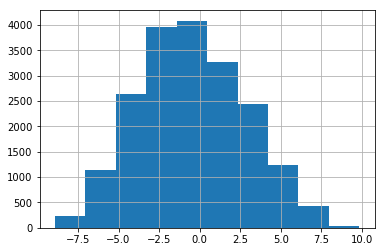

In [94]:
post[parameter].iloc[500:].hist()

In [95]:
def wrapper(theta):
    T = pd.DataFrame([
        [1,0,0,0],
        [0,-1,-1,-theta[0]],
        [0,1,0,0],
        [0,0,1,0],
    ])

    H = pd.DataFrame([0.3])

    Q = pd.DataFrame([
        [0.1,0],
        [0,0.2],
    ])

    kf = KalmanFilter(y=y, 
                      Z=Z.astype(float), 
                      H=H.astype(float), 
                      T=T.astype(float), 
                      Q=Q.astype(float), 
                      a1=a1.astype(float), 
                      P1=P1.astype(float), 
                      R=R.astype(float), 
                      nStates=4)    

    return kf.likelihood()


In [96]:
# %%timeit -n 3

sample = 20000

thetaMH = []
accept = np.zeros([sample])

thetaMH.append(np.array([0.5]))

sigmas = np.array([1])


priorMeans = np.array([0])

priorVariances = 3 * np.ones(1)

for i in range(1,sample):
    disturbance = np.multiply(np.random.randn(thetaMH[0].shape[0]),sigmas)
#     print(disturbance)
    thetaTemp = (thetaMH[i-1] + disturbance)
    lalpha = np.log(posterior(thetaTemp,priorMeans, priorVariances)) - np.log(posterior(thetaMH[i-1],priorMeans, priorVariances))
    r = np.min([1, np.exp(lalpha)])
    
    u = np.random.uniform()
    
    if u < r:
        accept[i] = 1
        thetaMH.append(thetaTemp)
    else:
        thetaMH.append(thetaMH[i-1])
    
    

In [97]:
post = pd.DataFrame(thetaMH)

In [98]:
accept.sum() / accept.shape[0]

0.90749999999999997

In [99]:
parameter = 0

In [100]:
post[parameter].iloc[500:].median()

0.2895795714748521

In [101]:
post[parameter].iloc[500:].mean()

0.29904547351032423

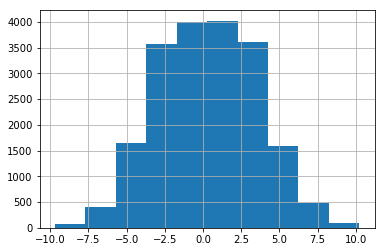

In [102]:
post[parameter].iloc[500:].hist()